In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
## Imports and Dataset Loading

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load data
data_path = 'US-National-Parks_RecreationVisits_1979-2023.csv'
data = pd.read_csv(data_path)

# Prepare data for visualizations
total_visits_by_region = data.groupby(['Region', 'Year'])['RecreationVisits'].sum().unstack(0)
total_visits_by_park = data.groupby('ParkName')['RecreationVisits'].sum().sort_values(ascending=False).head(10)
example_park = 'Acadia NP'
park_data = data[data['ParkName'] == example_park]
regional_share = data.groupby('Region')['RecreationVisits'].sum()




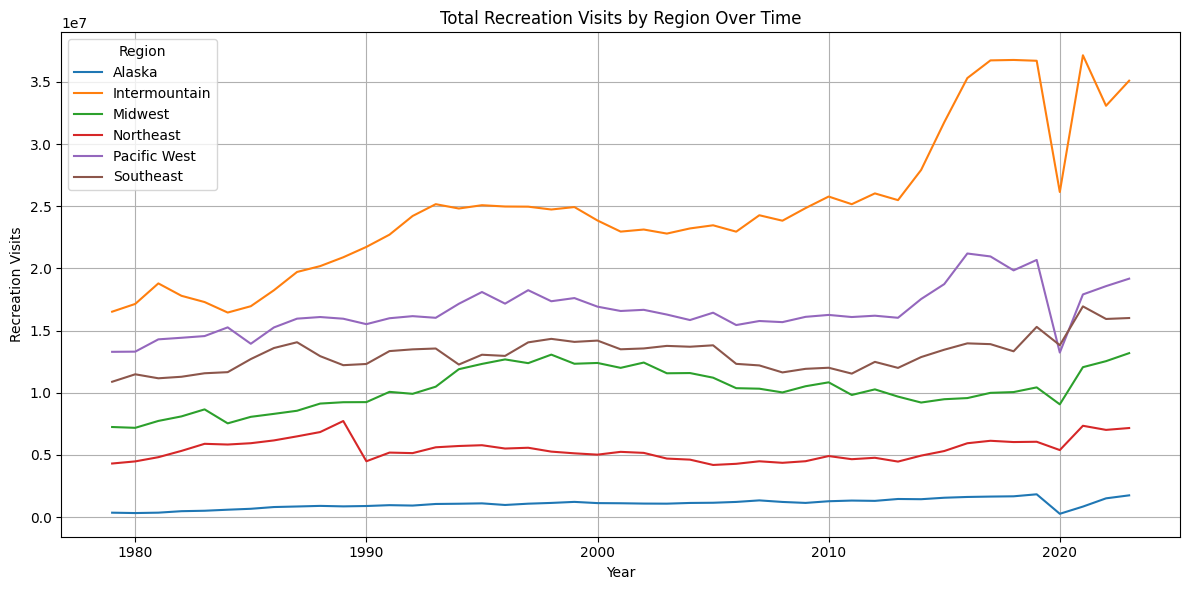

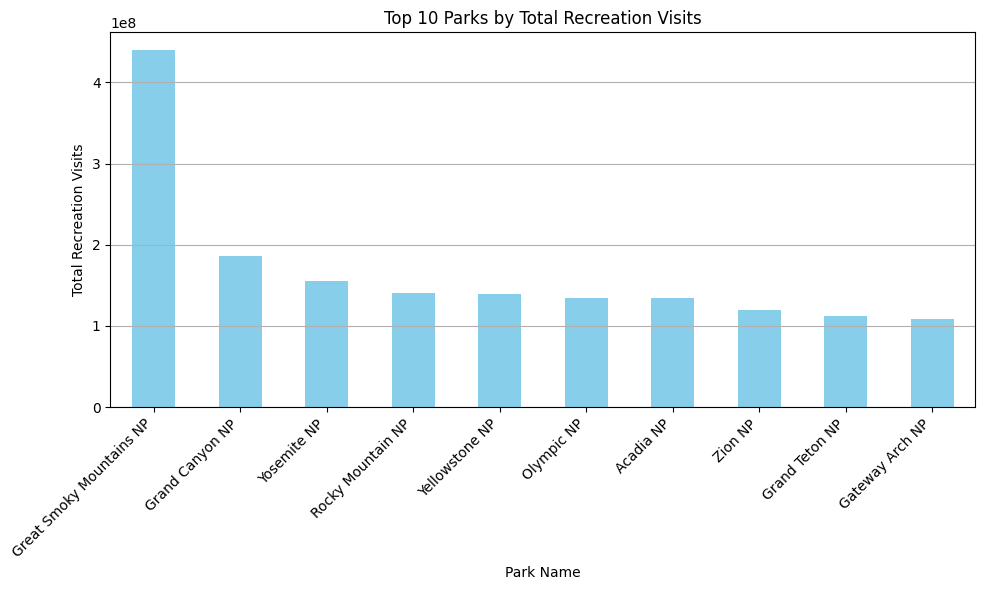

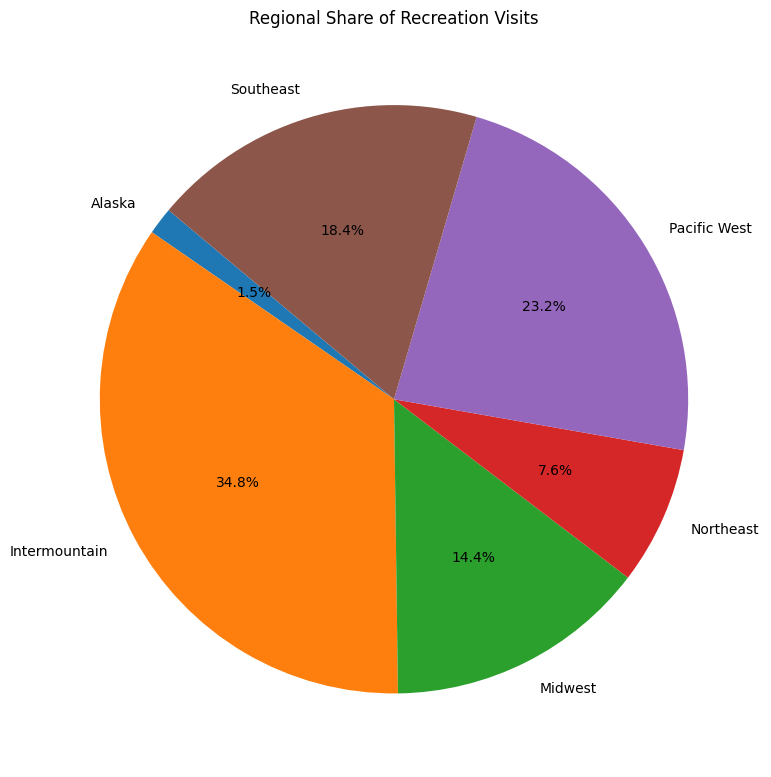

Total Number of National Parks in Each Region:
Region
Alaska            8
Intermountain    19
Midwest           9
Northeast         3
Pacific West     17
Southeast         7
Name: ParkName, dtype: int64


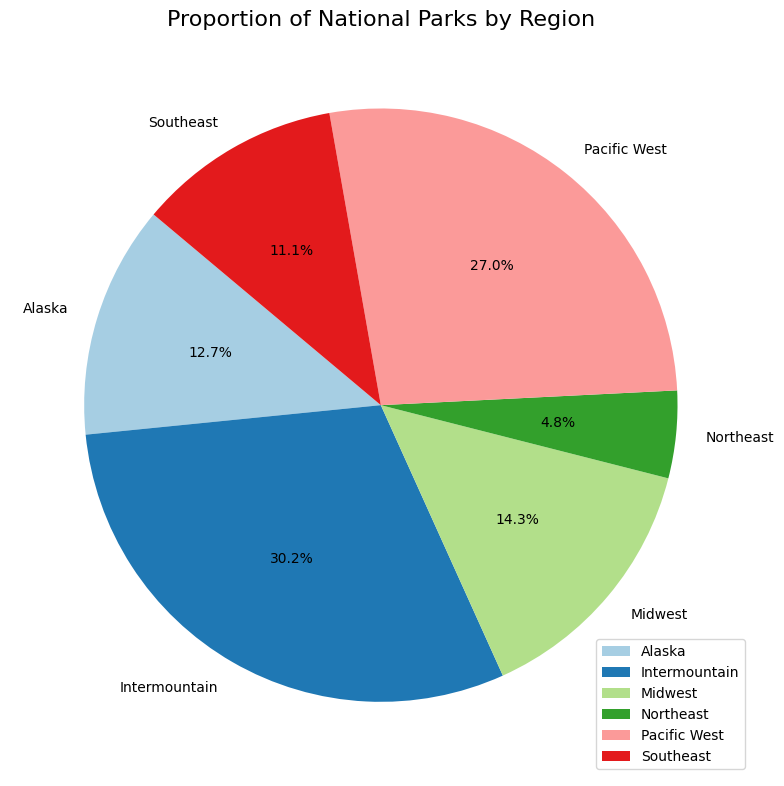

In [5]:
## 1. Total Recreation Visits by Region Over Time
plt.figure(figsize=(12, 6))
total_visits_by_region.plot(ax=plt.gca())
plt.title('Total Recreation Visits by Region Over Time')
plt.xlabel('Year')
plt.ylabel('Recreation Visits')
plt.legend(title='Region')
plt.grid()
plt.tight_layout()
plt.show()

## 2. Top Parks by Total Recreation Visits
plt.figure(figsize=(10, 6))
total_visits_by_park.plot(kind='bar', color='skyblue')
plt.title('Top 10 Parks by Total Recreation Visits')
plt.xlabel('Park Name')
plt.ylabel('Total Recreation Visits')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## 4. Regional Share of Recreation Visits
plt.figure(figsize=(8, 8))
regional_share.plot(kind='pie', autopct='%1.1f%%', startangle=140, )
plt.title('Regional Share of Recreation Visits')
plt.ylabel('')  # Hides the default y-axis label for better aesthetics
plt.tight_layout()
plt.show()

# Calculate the total number of unique national parks (NPs) in each region
parks_per_region = data.groupby('Region')['ParkName'].nunique()

# Display the results
print("Total Number of National Parks in Each Region:")
print(parks_per_region)

plt.figure(figsize=(8, 8))
parks_per_region.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors, legend=True)
plt.title('Proportion of National Parks by Region', fontsize=16)
plt.ylabel('')  # Remove default ylabel for cleaner aesthetics
plt.tight_layout()
plt.show()


In [6]:
# Download U.S. states shapefile from a public URL (Census Bureau TIGER/Line)
!wget -q https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip -O us_states.zip
!unzip -q us_states.zip -d us_states


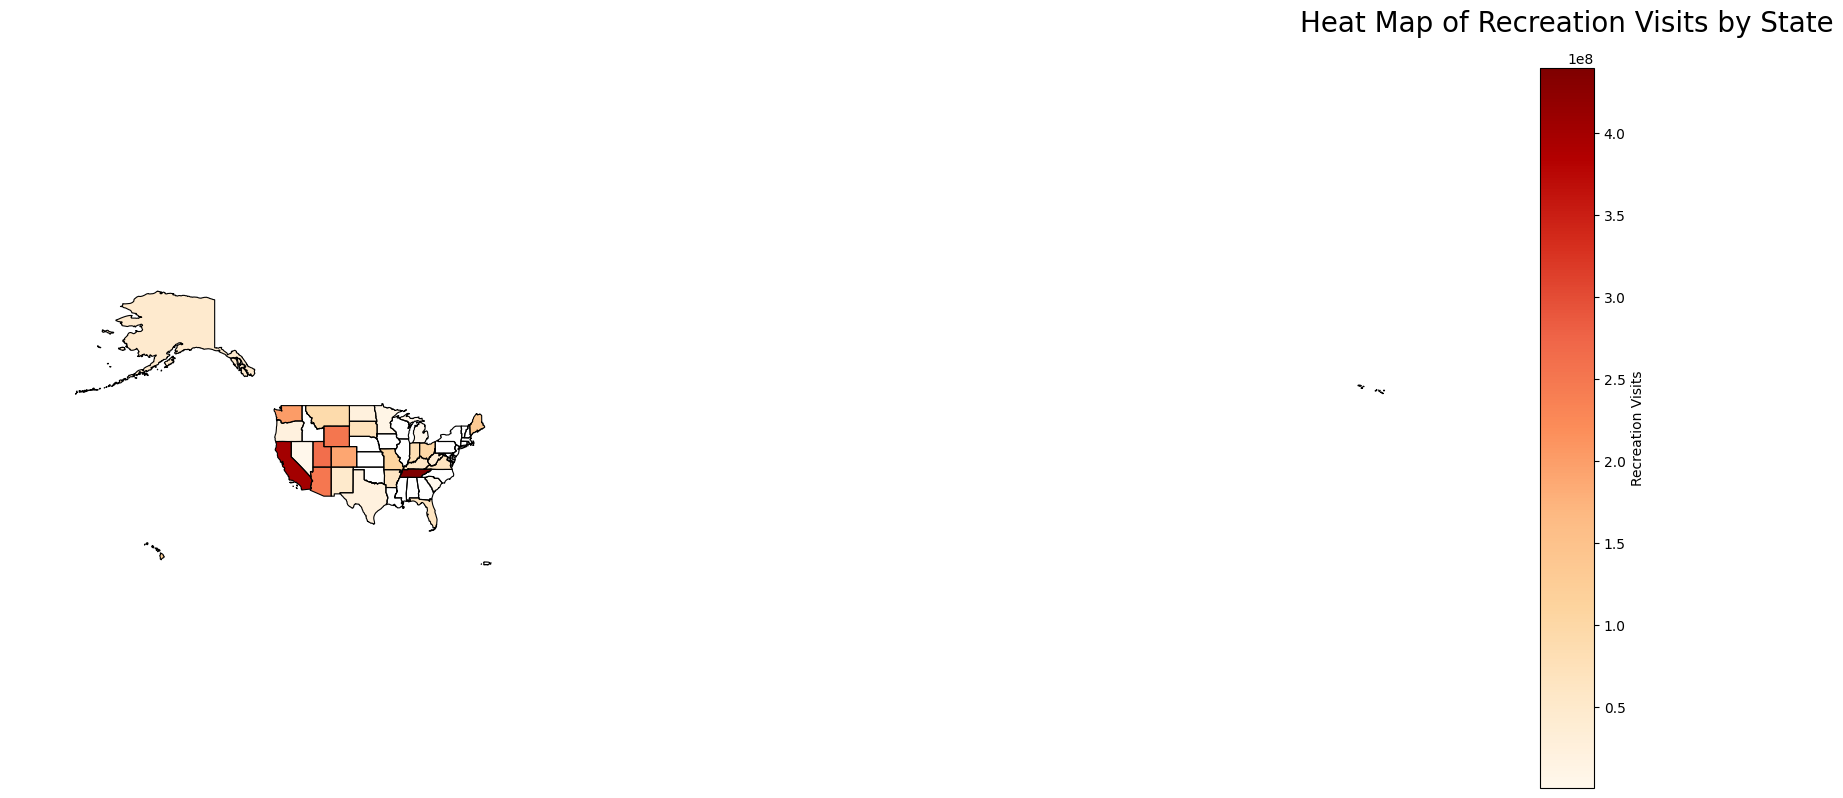

In [8]:
import geopandas as gpd
from matplotlib import colors

# Load shapefile into GeoPandas
usa_states = gpd.read_file("us_states/cb_2018_us_state_20m.shp")

# Clean up state names (if needed)
usa_states = usa_states.rename(columns={"STUSPS": "State"})

# Example dataset integration
state_visits = data.groupby('State')['RecreationVisits'].sum().reset_index()

# Merge state visits with the shapefile
state_visits = usa_states.merge(state_visits, on="State", how="left")

# Plot the heatmap with adjustments
fig, ax = plt.subplots(1, 1, figsize=(18, 12))  # Increase figure size for better resolution

# Plot the state boundaries
state_visits.boundary.plot(ax=ax, linewidth=0.8, color='black')

# Define a position for the color bar
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=colors.Normalize(vmin=state_visits['RecreationVisits'].min(), vmax=state_visits['RecreationVisits'].max()))
cax = fig.add_axes([0.9, 0.2, 0.03, 0.6])  # [left, bottom, width, height]

# Plot the states with the heatmap
state_visits.plot(column='RecreationVisits', cmap='OrRd', legend=True, ax=ax,
                  legend_kwds={'label': "Recreation Visits", 'orientation': "vertical", 'shrink': 0.7}, cax=cax)

# Add title and adjust layout
plt.title('Heat Map of Recreation Visits by State', fontsize=20, pad=15)  # Larger, more readable title
ax.axis('off')  # Remove axes for a cleaner map
plt.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.05)  # Adjust layout for better spacing
plt.show()


Model Equation: RecreationVisits = -14271179.50 + 7323.90*Year + 155197.60*Region + 35946.39*State


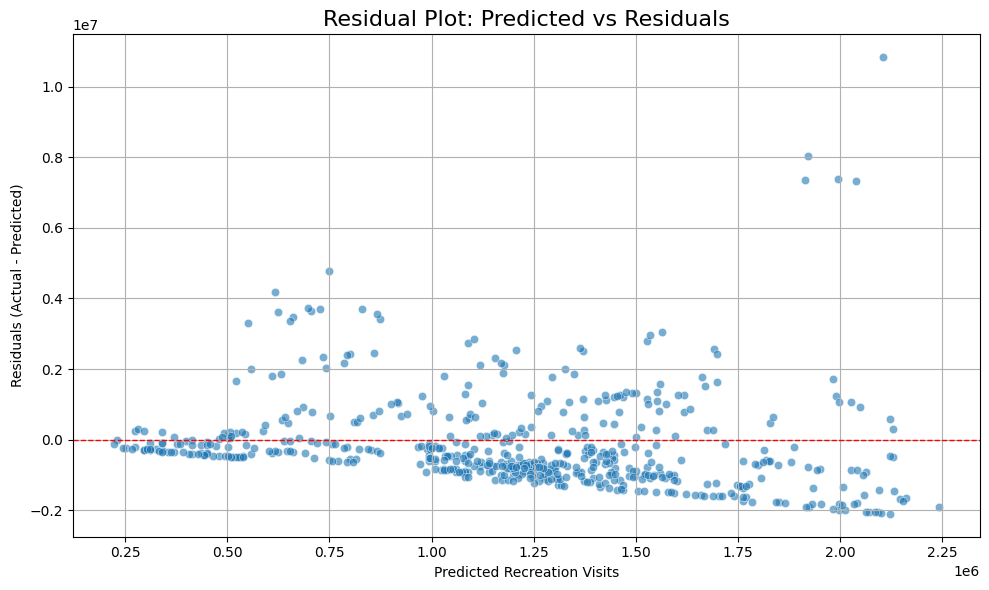

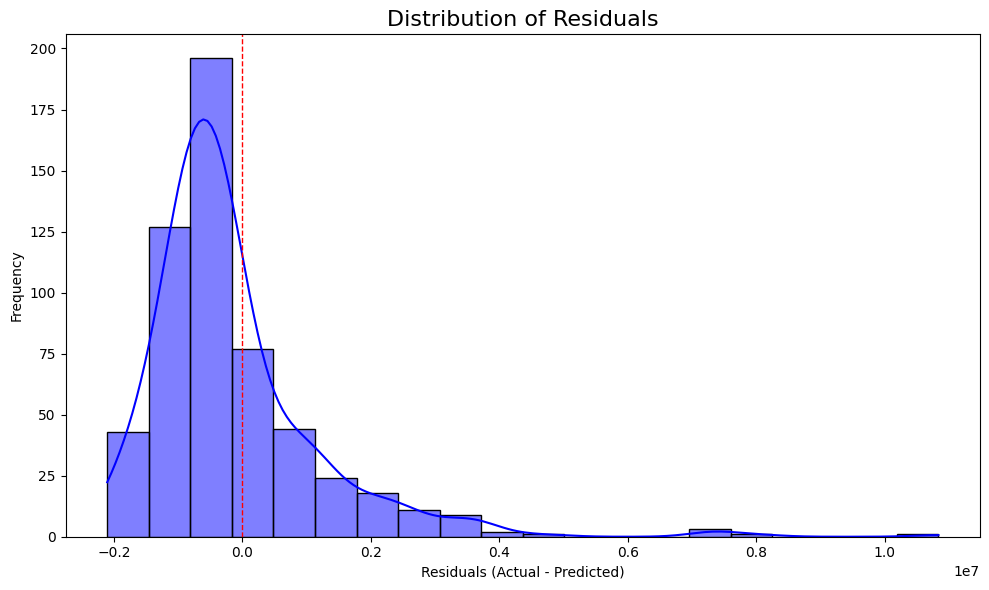

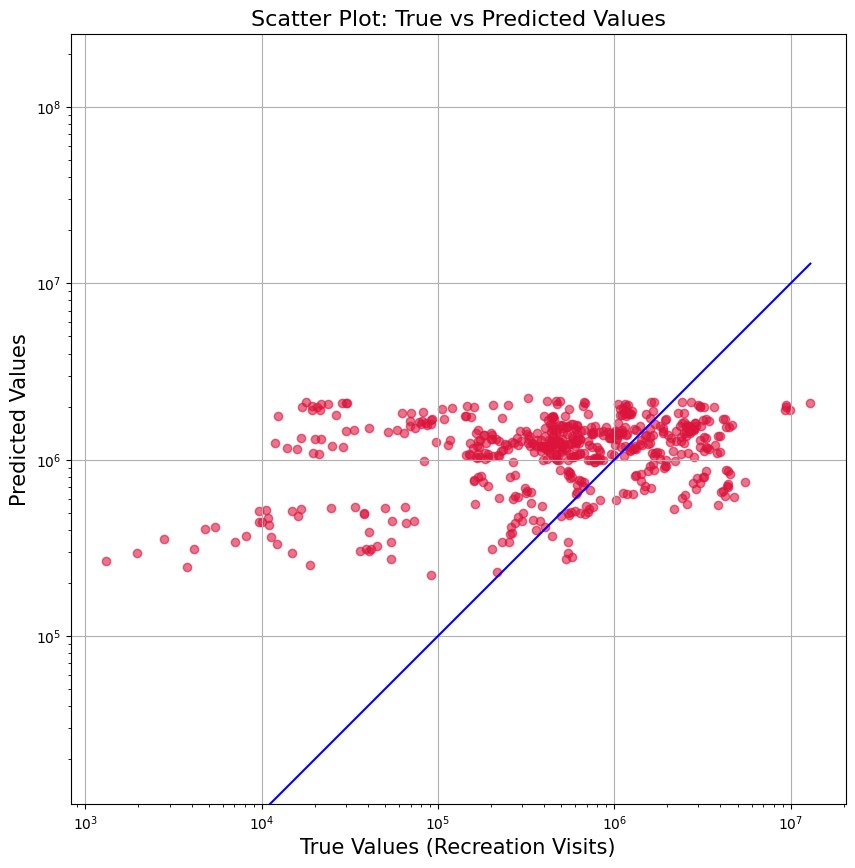

In [9]:
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Feature engineering
data_ml = data.copy()
data_ml['Region'] = data_ml['Region'].astype('category').cat.codes
data_ml['State'] = data_ml['State'].astype('category').cat.codes
X = data_ml[['Year', 'Region', 'State']]
y = data_ml['RecreationVisits']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Model Equation
coefficients = linear_model.coef_
intercept = linear_model.intercept_
print("Model Equation: RecreationVisits = {:.2f} + {:.2f}*Year + {:.2f}*Region + {:.2f}*State".format(
    intercept, coefficients[0], coefficients[1], coefficients[2]))

# Predictions
y_pred = linear_model.predict(X_test)

# Residuals
residuals = y_test - y_pred

# Residual Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residual Plot: Predicted vs Residuals', fontsize=16)
plt.xlabel('Predicted Recreation Visits')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid()
plt.tight_layout()
plt.show()

# Distribution Plot of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=20, color='blue')
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.title('Distribution of Residuals', fontsize=16)
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Scatter Plot: True vs Predicted Values
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred, c='crimson', alpha=0.6)
plt.yscale('log')
plt.xscale('log')

# Plot diagonal line (perfect predictions)
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')

plt.title('Scatter Plot: True vs Predicted Values', fontsize=16)
plt.xlabel('True Values (Recreation Visits)', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.axis('equal')
plt.grid()
plt.show()
